# An oscillating tragedy of the commons in replicator dynamics with game–environment feedback

- Hamza Dardari   (0587392 - VUB)  
- Mounir Siraje   (0590956 - VUB)  
- Rayane Kouidane (0587073 - VUB)

This notebook reproduces and explores the results presented in:

> Weitz, J. S., Eksin, C., Paarporn, K., Brown, S. P., & Ratcliff, W. C. (2016).  
> *An oscillating tragedy of the commons in replicator dynamics with game–environment feedback.*  
> *Proceedings of the National Academy of Sciences*, 113(47), E7518–E7525.  
> https://doi.org/10.1073/pnas.1604096113


---
### Libraries

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import expit 

---
### Figure 2

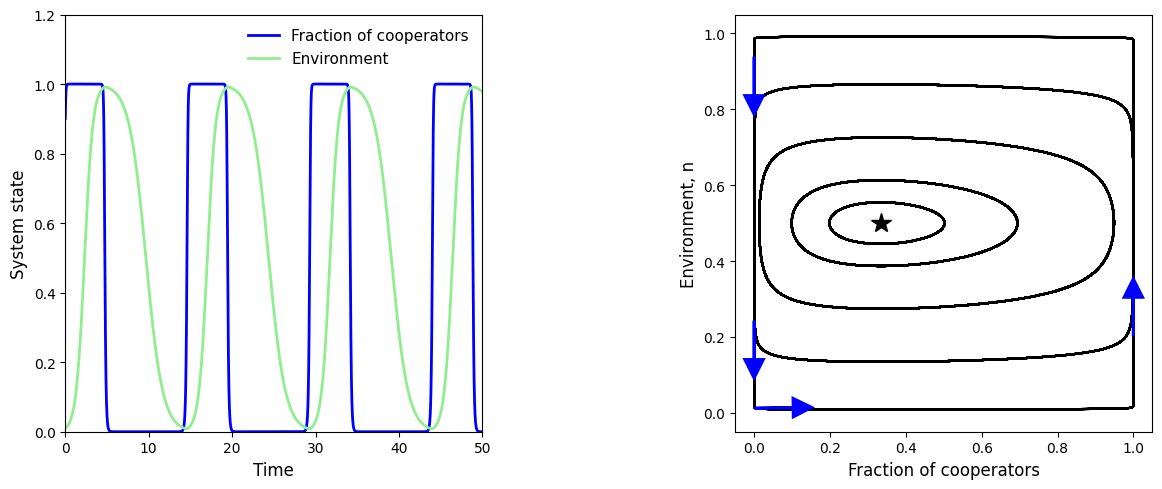

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def get_payoff_matrix(n, A0, A1):
    return (1 - n) * A0 + n * A1

def get_fitness_diff_coeffs(n, A0, A1):
    A = get_payoff_matrix(n, A0, A1)
    R, S = A[0, 0], A[0, 1]
    T, P = A[1, 0], A[1, 1]
    b = S - P
    a = (R - T) - b
    return a, b

def system_for_figure_2(t, y, epsilon, theta, A0, A1):
    x, n = y
    a, b = get_fitness_diff_coeffs(n, A0, A1)
    dxdt = x * (1 - x) * (a * x + b) / epsilon
    dndt = n * (1 - n) * (-1 + (1 + theta) * x)
    return [dxdt, dndt]

def reproduce_figure_2():
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3, 0, 5, 1
    
    A0 = np.array([[T, P], [R, S]])
    A1 = np.array([[R, S], [T, P]])
    
    x_star = 1 / (1 + theta)
    n_star = 0.5
    
    initial_conditions = [
        (0.9, 0.01),
        (0.8, 0.15),
        (0.7, 0.3),
        (0.5, 0.4),
        (0.4, 0.45),
    ]
    
    sol_display = solve_ivp(
        system_for_figure_2,
        (0, 50),
        initial_conditions[0],
        args=(epsilon, theta, A0, A1),
        rtol=1e-7, atol=1e-11, max_step=0.01
    )
    
    solutions = []
    for x0, n0 in initial_conditions:
        sol = solve_ivp(
            system_for_figure_2,
            (0, 200),
            [x0, n0],
            args=(epsilon, theta, A0, A1),
            rtol=1e-7, atol=1e-11, max_step=0.05
        )
        solutions.append(sol)
    
    fig, (ax_time, ax_phase) = plt.subplots(1, 2, figsize=(14, 5))
    
    # LEFT: Time series
    ax_time.plot(sol_display.t, sol_display.y[0], 'b-', lw=2, label='Fraction of cooperators')
    ax_time.plot(sol_display.t, sol_display.y[1], color='lightgreen', lw=2, label='Environment')
    ax_time.set_xlabel('Time', fontsize=12)
    ax_time.set_ylabel('System state', fontsize=12)
    ax_time.set_xlim(0, 50)
    ax_time.set_ylim(0, 1.2)
    ax_time.legend(loc='upper right', frameon=False, fontsize=11)
    ax_time.set_aspect(50/1.2)
    
    # RIGHT: Phase plane
    for sol in solutions:
        ax_phase.plot(sol.y[0], sol.y[1], 'k-', lw=1.5)
    
    sol_arrow = solutions[0]
    x_traj = sol_arrow.y[0]
    n_traj = sol_arrow.y[1]
    n_points = len(x_traj)
    
    x_range = x_traj.max() - x_traj.min()
    n_range = n_traj.max() - n_traj.min()
    avg_range = (x_range + n_range) / 2
    
    arrow_fractions = [1/8, 3/8, 5/8, 7/8]
    
    for frac in arrow_fractions:
        idx = int(frac * n_points)
        if idx >= n_points - 1:
            continue
            
        x_pos = x_traj[idx]
        n_pos = n_traj[idx]
        
        look_ahead = max(1, int(n_points * 0.01))
        next_idx = min(idx + look_ahead, n_points - 1)
        
        dx = x_traj[next_idx] - x_traj[idx]
        dn = n_traj[next_idx] - n_traj[idx]
        
        norm = np.sqrt(dx**2 + dn**2)
        if norm > 0:
            arrow_length = avg_range / 10
            dx_arrow = arrow_length * dx / norm
            dn_arrow = arrow_length * dn / norm
            head_size = arrow_length / 2
            
            ax_phase.arrow(x_pos, n_pos, dx_arrow, dn_arrow,
                          head_width=head_size, head_length=head_size, 
                          fc='blue', ec='blue', lw=2, zorder=10)
    
    ax_phase.plot(x_star, n_star, '*', color='black', markersize=15, zorder=20)
    ax_phase.set_xlabel('Fraction of cooperators', fontsize=12)
    ax_phase.set_ylabel('Environment, n', fontsize=12)
    ax_phase.set_xlim(-0.05, 1.05)
    ax_phase.set_ylim(-0.05, 1.05)
    ax_phase.set_aspect('equal') 
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

---

### Reproduction of Figure 3

In [102]:
import numpy as np

def get_payoff_matrix(n, A0, A1):
    # Payoff depends on environment
    return (1 - n) * A0 + n * A1

def get_fitness_diff_coeffs(n, A0, A1):
    # Calculate coefficients a, b such that fitness difference = ax + b
    A = get_payoff_matrix(n, A0, A1)
    
    R, S = A[0, 0], A[0, 1]
    T, P = A[1, 0], A[1, 1]
    
    b = S - P
    a = (R - T) - b
    return a, b

def fast_slow_system(t, y, epsilon, theta, A0, A1):
    x, n = y
    
    # Calculate fitness difference coeffs
    a, b = get_fitness_diff_coeffs(n, A0, A1)
    
    # System dynamics
    dxdt = x * (1 - x) * (a * x + b)
    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x)
    
    return [dxdt, dndt]

def get_bifurcation_points(A0, A1):
    bif_points = []
    
    # Get coeffs at the environmental boundaries
    a0, b0 = get_fitness_diff_coeffs(0, A0, A1)
    a1, b1 = get_fitness_diff_coeffs(1, A0, A1)

    # Bifurcation near x=0 (check where b(n) crosses 0)
    if b1 != b0:
        n_crit = -b0 / (b1 - b0)
        if 0 <= n_crit <= 1:
            bif_points.append((0, n_crit))

    # Bifurcation near x=1 (check where a(n) + b(n) crosses 0)
    val0 = a0 + b0
    val1 = a1 + b1
    if val1 != val0:
        n_crit = -val0 / (val1 - val0)
        if 0 <= n_crit <= 1:
            bif_points.append((1, n_crit))
            
    return bif_points

In [103]:
def plot_expected_fast_dynamics(ax, A0, A1):
    def plot_arrow(x, n):
        # The direction of the arrow depends on the sign of x' = x(1-x)(ax + b)
        # and because x(1-x) > 0 in the interior, the sign depends on (ax + b)
        a, b = get_fitness_diff_coeffs(n, A0, A1)
        d = a * x + b
        marker = '>' if d > 0 else '<'
        ax.plot(x, n, marker=marker, color='black', markersize=6)

    # We want 11 evenly-spaced blue lines
    n_levels = np.linspace(0, 1.0, 11)
    for n in n_levels:
        ax.plot([0, 1], [n, n], color='blue', lw=1, alpha=0.8)
        plot_arrow(0.25, n)
        plot_arrow(0.75, n)

def plot_boundary(ax, A0, A1):
    # Sample n values for the boundary
    n_vals = np.linspace(0, 1, 500)

    # Compute a(n) and b(n)
    a_vals = []
    b_vals = []
    for n in n_vals:
        a, b = get_fitness_diff_coeffs(n, A0, A1)
        a_vals.append(a)
        b_vals.append(b)

    # x = 0 is stable when b(n) < 0
    x0_stable = []
    x0_unstable = []
    for n, b in zip(n_vals, b_vals):
        if b < 0:
            x0_stable.append(n)
        else:
            x0_unstable.append(n)

    # x = 1 is stable when a(n) + b(n) > 0
    x1_stable = []
    x1_unstable = []
    for n, a, b in zip(n_vals, a_vals, b_vals):
        if a + b > 0:
            x1_stable.append(n)
        else:
            x1_unstable.append(n)

    # Draw x = 0
    ax.plot([0]*len(x0_stable), x0_stable, 'k-', lw=2)
    ax.plot([0]*len(x0_unstable), x0_unstable, 'k--', lw=2)

    # Draw x = 1
    ax.plot([1]*len(x1_stable), x1_stable, 'k-', lw=2)
    ax.plot([1]*len(x1_unstable), x1_unstable, 'k--', lw=2)
    
    for y in [0.2, 0.5, 0.8]:
        ax.arrow(0, y, 0, -0.001, head_width=0.035, color='k')
        ax.arrow(1, y, 0,  0.001, head_width=0.035, color='k')

def plot_interior_manifold(ax, theta, A0, A1):
    # Sample n values for the interior
    n_vals = np.linspace(0.01, 0.99, 600)

    # Compute a(n) and b(n)
    a_vals = [get_fitness_diff_coeffs(n, A0, A1)[0] for n in n_vals]
    b_vals = [get_fitness_diff_coeffs(n, A0, A1)[1] for n in n_vals]

    # Compute interior fixed points x* = -b/a
    interior = [(-b / a, n, a) for n, a, b in zip(n_vals, a_vals, b_vals) if abs(a) >= 1e-6 and 0 <= -b / a <= 1]
    if not interior:
        return

    # Separate stable and unstable parts (a < 0 is stable)
    x_stable = []
    n_stable = []
    x_unstable = []
    n_unstable = []
    for x, n, a in interior:
        if a < 0:
            x_stable.append(x)
            n_stable.append(n)
        else:
            x_unstable.append(x)
            n_unstable.append(n)

    # Draw interior manifold
    ax.plot(x_stable, n_stable, 'k-', lw=2)
    ax.plot(x_unstable, n_unstable, 'k--', lw=2)

    # Add direction arrows on the slow manifold (We show 2 arrows)
    for idx in [int(len(interior) * 0.35), int(len(interior) * 0.8)]:
        # Unpack current point
        x, n, _ = interior[idx]
        
        # Calculate tangent vector (using forward difference)
        # We just need the direction between this point and the next
        dx = interior[idx+1][0] - x
        dn = interior[idx+1][1] - n

        # Direction depends on the sign of -1 + (1 + theta) * x
        if (-1 + (1 + theta) * x) < 0:
            dx, dn = -dx, -dn
        
        ax.arrow(x, n, dx, dn, head_width=0.03, color='k')


def plot_time_series(ax, sol, title):
    ax.plot(sol.t, sol.y[0], label='Cooperators', color="blue")
    ax.plot(sol.t, sol.y[1], label='Environment', color="lightgreen")
    ax.set_title(title)
    ax.set_ylabel('System state')
    ax.set_xlim(0, sol.t[-1])
    ax.set_ylim(-0.05, 1.25)
    ax.legend()


def plot_phase_plane(ax, theta, A0, A1, sol, show_repeller=False):
    plot_expected_fast_dynamics(ax, A0, A1)
    plot_boundary(ax, A0, A1)
    plot_interior_manifold(ax, theta, A0, A1)

    # Bifurcation points
    for x, n in get_bifurcation_points(A0, A1):
        ax.plot(x, n, 'ro', markersize=8)

    # Repeller (case 1) or attractor (case 2)
    if show_repeller:
        ax.plot(1/(1+theta), 2/3, marker='D', color='red', markersize=8)
    else:
        ax.plot(sol.y[0][-1], sol.y[1][-1], marker='D', color='red', markersize=8)

    # Realized orbit
    ax.plot(sol.y[0], sol.y[1], color='grey', lw=1.5, alpha=0.9)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Cooperator fraction, x')
    ax.set_ylabel('Environment, n')

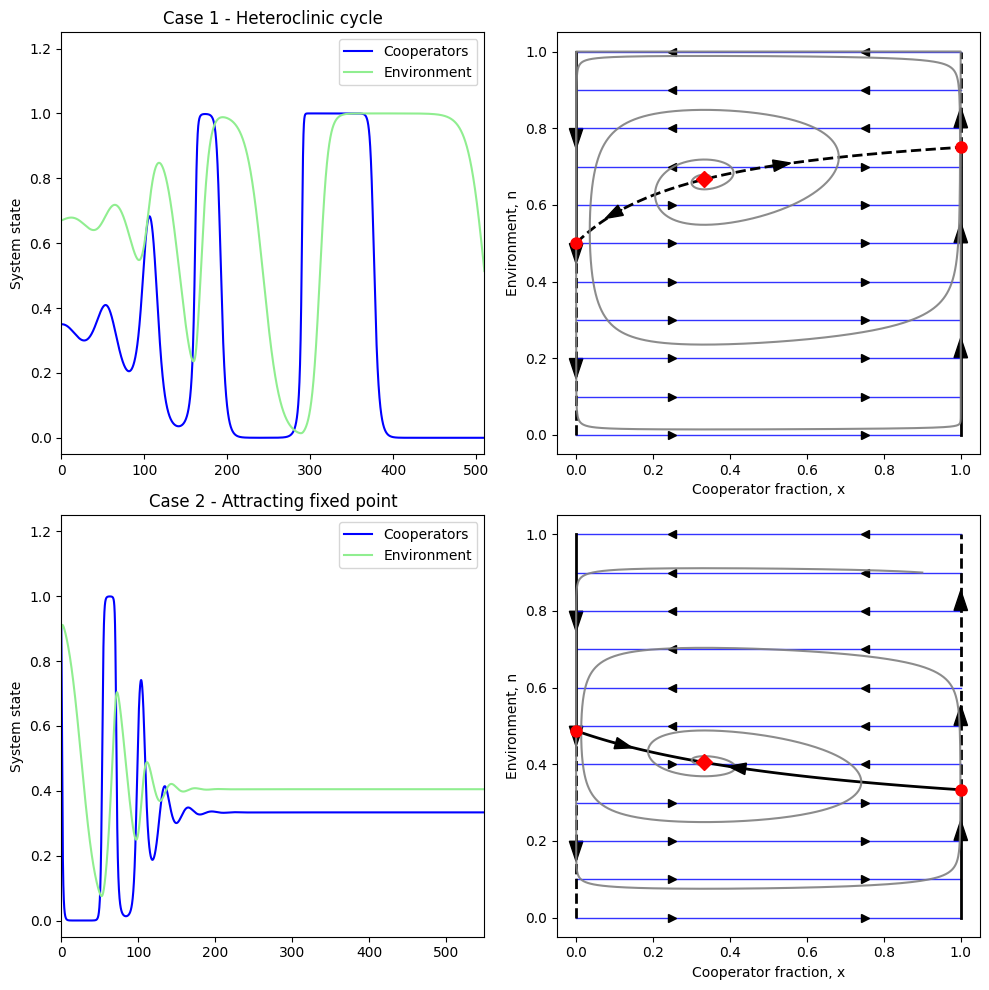

In [104]:
def reproduce_figure_3():
    epsilon = 0.1
    theta = 2.0
    
    # Case 1
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.67]

    sol_het = solve_ivp(fast_slow_system, (0, 510), y0_het, args=(epsilon, theta, A0_het, A1_het), rtol=1e-10, atol=1e-13, max_step=0.01)

    # Case 2
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.9, 0.9]

    sol_fix = solve_ivp(fast_slow_system, (0, 550), y0_fix, args=(epsilon, theta, A0_fix, A1_fix), rtol=1e-10, atol=1e-13, max_step=0.1)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Case 1
    plot_time_series(axes[0,0], sol_het, 'Case 1 - Heteroclinic cycle')
    plot_phase_plane(axes[0,1], theta, A0_het, A1_het, sol_het, show_repeller=True)

    # Case 2
    plot_time_series(axes[1,0], sol_fix, 'Case 2 - Attracting fixed point')
    plot_phase_plane(axes[1,1], theta, A0_fix, A1_fix, sol_fix)

    plt.tight_layout()
    plt.show()

reproduce_figure_3()

startpunten niet gelijk en paper zegt niet wat startpunten zijn.

---

### Reproduction of Figure 4

In [105]:
def plot_case_time_series(ax_left, ax_right, epsilon, theta, t_span, het_params, fix_params):
    # Case 1
    sol_het = solve_ivp(fast_slow_system, t_span, het_params[2], args=(epsilon, theta, het_params[0], het_params[1]), rtol=1e-10, atol=1e-13, max_step=0.1)
    ax_left.plot(sol_het.t, sol_het.y[0], color="blue", lw=2)
    ax_left.plot(sol_het.t, sol_het.y[1], color="lightgreen", lw=2)
    ax_left.text(5, 0.05, f'ε = {epsilon}', fontsize=11)

    # Case 2
    sol_fix = solve_ivp(fast_slow_system, t_span, fix_params[2], args=(epsilon, theta, fix_params[0], fix_params[1]), rtol=1e-10, atol=1e-13, max_step=0.1)
    ax_right.plot(sol_fix.t, sol_fix.y[0], color="blue", lw=2)
    ax_right.plot(sol_fix.t, sol_fix.y[1], color="lightgreen", lw=2)   
    ax_right.text(150, 0.05, f'ε = {epsilon}', fontsize=11)

    for ax in [ax_left, ax_right]:
        ax.set_xlim(0, 200)
        ax.set_ylim(-0.03, 1.1)
        ax.set_ylabel('System state')

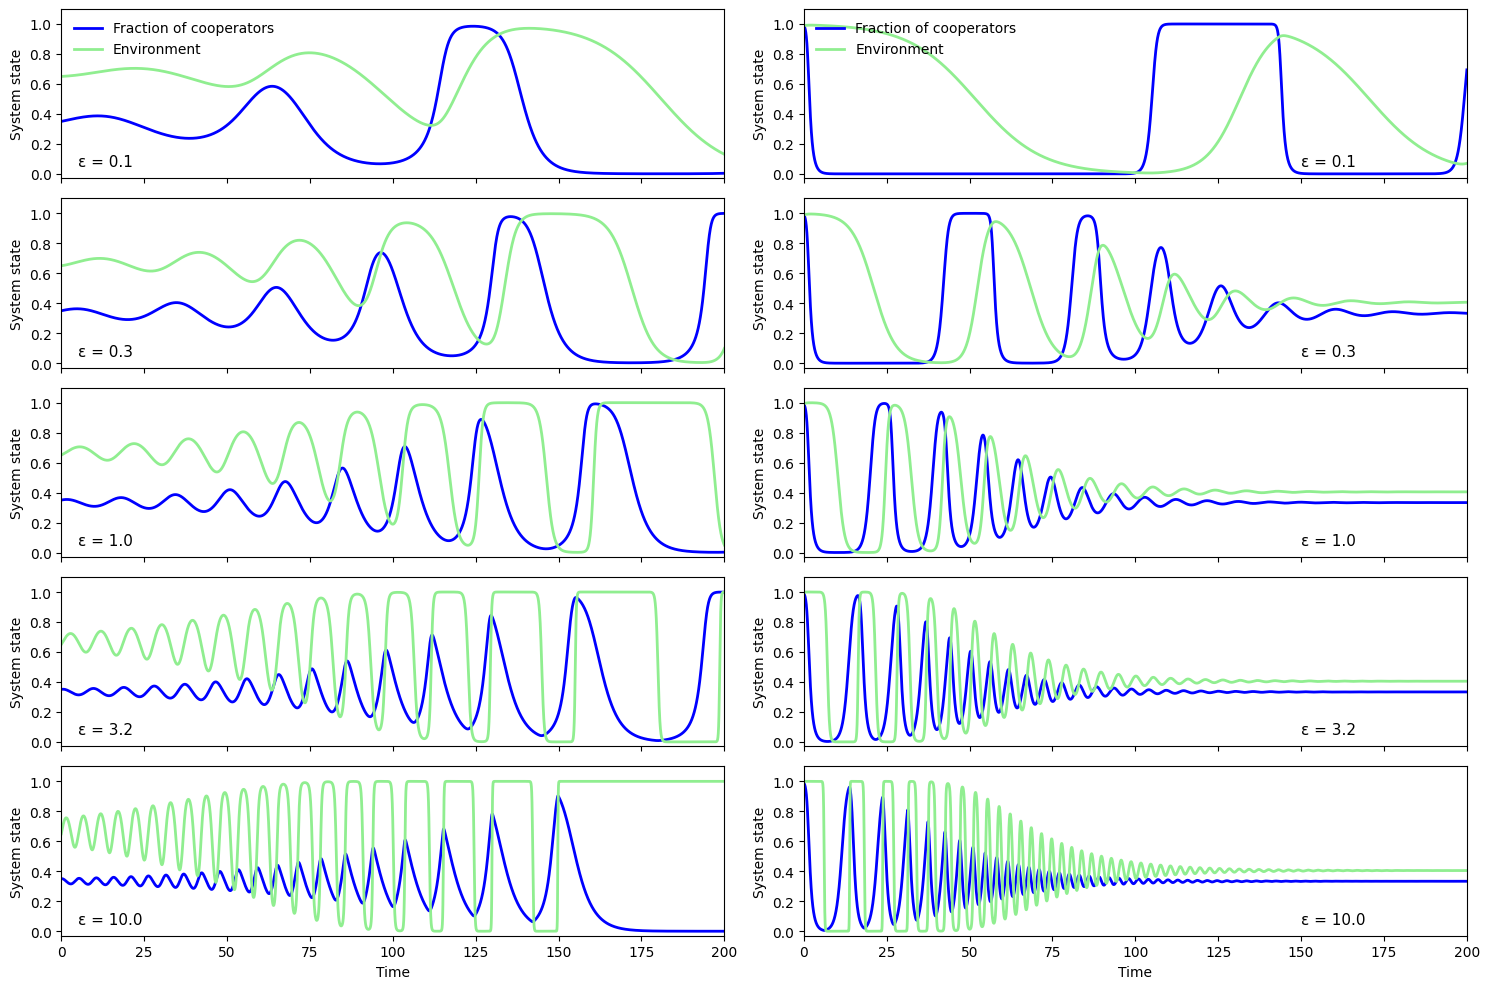

In [106]:
def reproduce_figure_4():
    epsilon_values = [0.1, 0.3, 1.0, 3.2, 10.0]
    theta = 2.0
    t_span = (0, 200)
    
    # Case 1
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.65] 
    het_params = [A0_het, A1_het, y0_het]
    
    # Case 2
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.99, 0.99]
    fix_params = [A0_fix, A1_fix, y0_fix]

    fig, axes = plt.subplots(len(epsilon_values), 2, figsize=(15, 10), sharex=True)

    for i, epsilon in enumerate(epsilon_values):
        plot_case_time_series(axes[i, 0], axes[i, 1], epsilon, theta, t_span, het_params, fix_params)

    # Legends on top row only
    axes[0, 0].legend(['Fraction of cooperators', 'Environment'], loc='upper left', frameon=False)
    axes[0, 1].legend(['Fraction of cooperators', 'Environment'], loc='upper left', frameon=False)

    # x labels on bottom row only
    axes[-1, 0].set_xlabel('Time')
    axes[-1, 1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

reproduce_figure_4()

---
### Extension

In [57]:
def sigmoid(n, threshold, k=50):
    # Returns 1.0 when n < threshold (control is active)
    # Returns 0.0 when n > threshold (control is inactive)
    return expit(-k * (n - threshold))

def fast_slow_system_extension(t, y, epsilon, theta, A0, A1, control_policy=None, threshold=0.3, intensity=0.0):
    x, n = y
    
    a, b = get_fitness_diff_coeffs(n, A0, A1)
    
    # Check if the environment is in the "danger zone" (below threshold)
    control_active = sigmoid(n, threshold)
    
    # 'Subsidy' control policy
    if control_policy == 'subsidy':
        b += intensity * control_active

    dxdt = x * (1 - x) * (a * x + b)
    
    # 'Restoration' control policy
    restoration_rate = 0
    if control_policy == 'restoration':
        restoration_rate = intensity * control_active

    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x) + restoration_rate * (1 - n)
    
    return [dxdt, dndt]

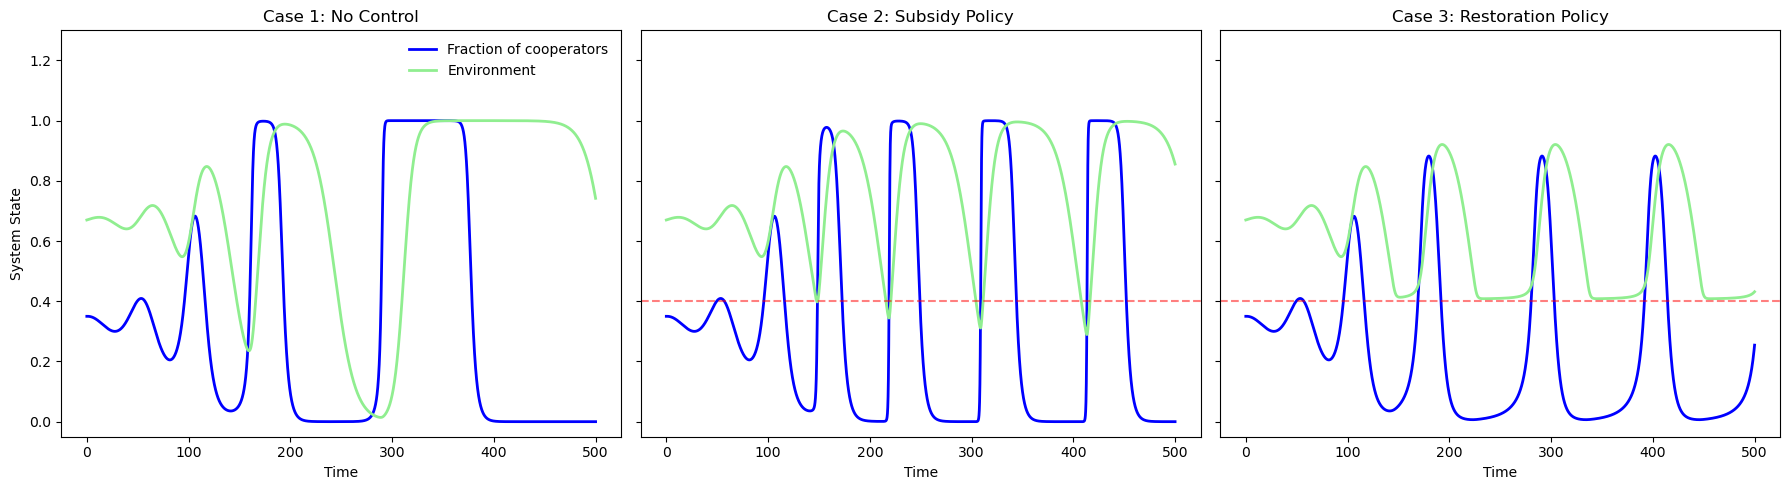

In [63]:
def plot_policy_comparison():
    epsilon = 0.1
    theta = 2.0
    threshold = 0.4 # Control policies kick in when environment drops below threshold
    subsidy = 2.0 # Bonus that is added to cooperators' payoffs
    restore = 0.1 # Manual environment restoration rate

    A0 = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1 = np.array([[4.0, 1.0], [4.5, 1.25]]) 
    
    y0 = [0.35, 0.67]
    t_span = (0, 500)

    sol_base = solve_ivp(fast_slow_system_extension, t_span, y0, args=(epsilon, theta, A0, A1, 'none'), rtol=1e-8, atol=1e-10, max_step=0.1)
    
    sol_subsidy = solve_ivp(fast_slow_system_extension, t_span, y0, args=(epsilon, theta, A0, A1, 'subsidy', threshold, subsidy), rtol=1e-8, atol=1e-10, max_step=0.1)
    
    sol_restore = solve_ivp(fast_slow_system_extension, t_span, y0, args=(epsilon, theta, A0, A1, 'restoration', threshold, restore), rtol=1e-8, atol=1e-10, max_step=0.1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    cases = [
        (sol_base, "Case 1: No Control"),
        (sol_subsidy, "Case 2: Subsidy Policy"),
        (sol_restore, "Case 3: Restoration Policy")
    ]
    
    for i, case in enumerate(cases):
        ax = axes[i]
        sol = case[0]
        title = case[1]
        ax.plot(sol.t, sol.y[0], label='Fraction of cooperators', color='blue', lw=2)
        ax.plot(sol.t, sol.y[1], label='Environment', color='lightgreen', lw=2)

         # Draw the red line for threshold only for case 2 and 3
        if ax != axes[0]:
            ax.axhline(y=threshold, color='red', alpha=0.5, label='Threshold', ls='--')
            
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylim(-0.05, 1.3)
        
    axes[0].set_ylabel('System State')
    axes[0].legend(loc='upper right', frameon=False)
    plt.tight_layout()
    plt.show()

plot_policy_comparison()